In [ ]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import matplotlib.patches as mpathces 
import seaborn as sns 

# sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier

# sequential model modeling 
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization 
from keras import optimizers, metrics, callbacks

# oversampling imbalanced learning 
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE 

import optuna
from optuna.samplers import TPESampler
from optuna import Trial

# GoodleDrive mount
from google.colab import drive   
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier


import optuna
from optuna.samplers import TPESampler
from optuna import Trial

from google.colab import drive  # GoodleDrive mount 
drive.mount('/content/drive')

Mounted at /content/drive


# 1.preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # TRY one-hot encoding 
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 

# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)


# 3) scaling: only `X_???` values (continuous)
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = StandardScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

model = Sequential([
        # Input layer: ReLU (decide input size according to dimension)
        Dense(512, activation='relu', input_shape=(train_x.shape[-1],)),      

        # layer2: softmax  (output layer)
        Dense(3, activation='softmax')
        ])


model.compile(optimizer = optimizers.Adam(1e-4),  # decrease learning rate (default learning rate=1e-3) 
              loss='sparse_categorical_crossentropy',  # tow or more label classes (`Y_Class`: 0,1,2)
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    epochs=10,
                    batch_size=64,  # batch size: 2^x && half of data size(598/2) 
                    validation_split=0.2,
                    # callbacks=callbacks
                    )   

Epoch 1/10
8/8 [==============================] - 4s 33ms/step - loss: 0.8584 - accuracy: 0.6695 - val_loss: 0.9085 - val_accuracy: 0.6333
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.7364 - val_loss: 0.9080 - val_accuracy: 0.6417
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.6440 - accuracy: 0.7385 - val_loss: 0.9296 - val_accuracy: 0.6500
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.7636 - val_loss: 1.0604 - val_accuracy: 0.6250
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6232 - accuracy: 0.7720 - val_loss: 0.9168 - val_accuracy: 0.6250
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 0.5536 - accuracy: 0.7971 - val_loss: 1.0447 - val_accuracy: 0.6250
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.5530 - accuracy: 0.7929 - val_loss: 1.0145 - val_accuracy: 0.6250
Epoch 8/10
8/8 [=================

10/10 [==============================] - 0s 2ms/step


AttributeError: ignored

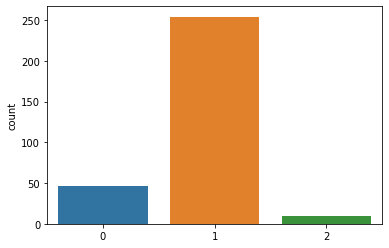

In [ ]:
preds = model.predict(test_x)
a=[]
for i in preds: 
    i = list(i)
    a.append(i.index(max(i)))
sns.countplot(x=a);  

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = a

submit.to_csv('ANN.stsc.trainx.b64-smartFactorySubmission.csv', index=False)

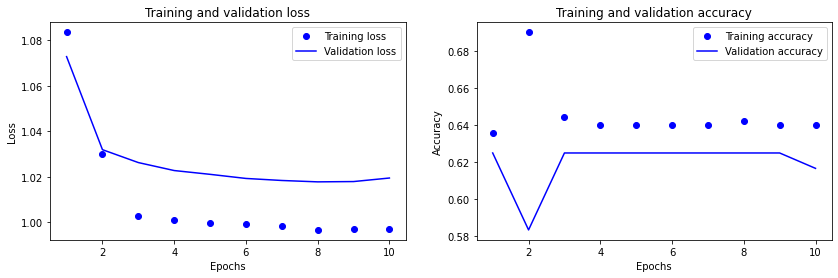

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(1,2,figsize=(14,4))
ax= axes.flatten()
a, b = ax[0], ax[1]

a.plot(epochs, history.history["loss"], "bo", label="Training loss")
a.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
a.set_title("Training and validation loss")
a.set_xlabel("Epochs")
a.set_ylabel("Loss")
a.legend()   

b.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
b.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
b.set_title("Training and validation accuracy")
b.set_xlabel("Epochs")
b.set_ylabel("Accuracy")
b.legend();